<a href="https://colab.research.google.com/github/khodid/2021MachineLearningIntro/blob/main/ch4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAPTER 4. 분류 실습
- p 183 ~ p 289

분류의 대표적 알고리즘
- 나이브 베이즈
- 로지스틱 회귀
- 결정 트리
- SVM
- KNN 알고리즘
- 뉴럴 네트워크
- 앙상블

이번 장에선 앙상블의 개요와 랜덤포래스트, 그래디언트 부스팅(XGBoost, LightBGM), 스태킹을 다룰 예정.

딥러닝이 이미지 영상 음성 자연어 등의 영역에서 머신러닝계를 선도하고 있으나 정형 데이터의 예측 분석은 앙상블이 더 애용되고 있음.

## 앙상블이란
- 서로 다른, 또는 같은 알고리즘을 결합하는 것
- 단순 결합, 배깅, 부스팅이 있다.
 - 보팅 : 서로 다른 알고리즘간의 결합
 - 배깅: 같은 알고리즘 기반으로 데이터 샘플링을 다르게 함. 예로는 랜덤 포레스트 -- 수행시간이 빠르고 유연성 있음
 - 부스팅: 최근 앙상블 기법에서 계속 발전되는 분야.그레이디언트 부스팅, XgBoost, LightBGM


## 결정 트리

- 유연하고 쉬운 알고리즘. 전처리의 영향을 덜 받음.
- 예측 성능을 향상시키는 게 까다롭고 오버피팅 위험이 큼. 

앙상블은 예측 성능이 떨어지는 학습 알고리즘을 결합하는데, 결정트리는 이 것에 좋은 재료로 사용된다.

### 파라미터
과적합 되기 쉬운 알고리즘이라 파라미터들이 죄다 과적합을 막기 위한 파라미터임.
- min_sample_split : 노드를 분할하기 위한 최소한의 샘플 데이터수. 작게 설정하면 분할을 더 해서 과적합됨
- min_samples_leaf : leaf가 되기 위한 최소한의 샘플 데이터수. 비대칭 데이터를 다룰 땐 작게 설정해야 한다.
- max_features : 분할에 쓰이는 최대 피쳐 수. 숫자를 넣을 수도 있고 퍼센트로 넣을 수 도 있고 'sqrt', 'auto', 'log', 'None' 과 같이 설정을 넣을 수 있음. 디폴트는 None(전체 피처 사용)
- max_depth : 트리의 최대 깊이
- max_leaf_nodes : leaf의 최대 개수



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') # 버전 업 관련 경고 메시지 무시하도록 함

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=358)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = 0.2, random_state = 35)

In [ ]:
iris_data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [ ]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=358, splitter='best')

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(dt_clf, out_file = "tree.dot", class_names = iris_data.target_names, feature_names = iris_data.feature_names, impurity = True, filled = True)
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# impurity : 불순도. 서로 다른 클래스의 데이터가 한 범주 안에 섞어있는 정도
# filled : True로 할 시 해당 노드에 들어간 다수 클래스가 구분되도록 색칠해줌

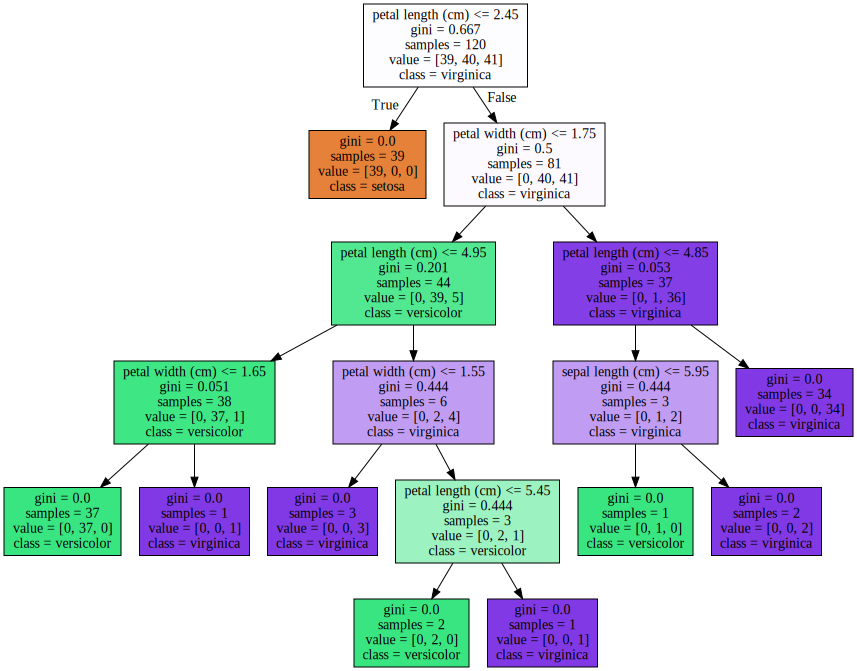

In [ ]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
from sklearn.metrics import accuracy_score
pred = dt_clf.predict(X_test)
accuracy_score(y_test, pred)


1.0

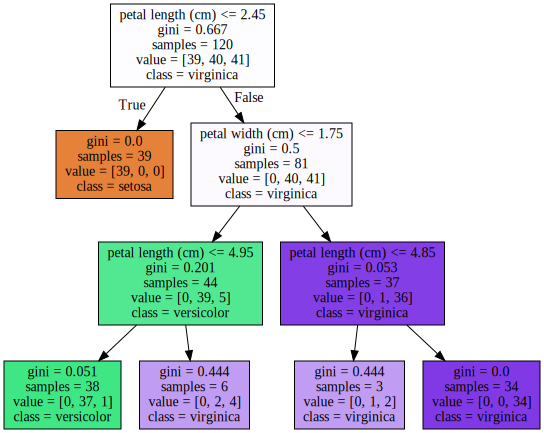

In [ ]:
# 파라미터 조정을 통해 과적합 개선

dt_clf_short = DecisionTreeClassifier(random_state=358, max_depth= 3, max_features=3, max_leaf_nodes=5)

dt_clf_short.fit(X_train, y_train)
export_graphviz(dt_clf, out_file = "tree.dot", class_names = iris_data.target_names, feature_names = iris_data.feature_names, impurity = True, filled = True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
print(accuracy_score(y_test, dt_clf_short.predict(X_test)))

1.0


오버피팅을 절제시켜야 모델이 간결하고, 간결한 모델은 이상치에 강한 모델이다.

Feature Importance : [0.    0.    0.599 0.401]
sepal length (cm) : 0.0
sepal width (cm) : 0.0
petal length (cm) : 0.5990564195917215
petal width (cm) : 0.40094358040827854


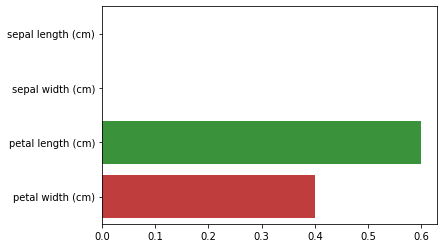

In [ ]:
import seaborn as sns
import numpy as np
%matplotlib inline

print("Feature Importance : {}".format(np.round(dt_clf.feature_importances_, 3)))
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{} : {}'.format(name, value))

sns.barplot(x = dt_clf.feature_importances_, y=iris_data.feature_names)

이렇듯 결정트리는 알고리즘 자체가 직관적이고 설명 가능해서 알고리즘과 관련된 시각적 요소를 표현할 수 있다.

## 결정 트리의 과적합

과적합 문제를 시각화하는 교재 내용.

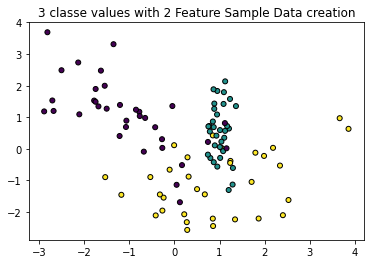

In [ ]:
from sklearn.datasets import make_classification # 분류를 위한 테스트용 데이터 생성하는 라이브러리
import matplotlib.pyplot as plt

plt.title("3 classe values with 2 Feature Sample Data creation")

X_features, y_labels = make_classification(n_features = 2, n_redundant = 0, n_informative = 2, n_classes = 3, n_clusters_per_class = 1, random_state = 0)

plt.scatter(X_features[:, 0], X_features[:, 1], marker = 'o', c = y_labels, s = 25, edgecolor = 'k')


## 앙상블 학습

### 앙상블 학습의 개요
- 여러개의 분류기를 생성하고 그 예측을 결합함. 집단지성 발휘하는 거임
- 보팅, 배깅, 부스팅 세 가지로 나눌 수 있음.
    - 보팅(Voting): 서로 다른 알고리즘을 같은 데이터세트에 대해 학습
    - 배깅(Bagging): 같은 알고리즘의 모델을 서로 다른 데이터 샘플(by Bootstapping, 중복 허용)에 대해 학습
    - 부스팅(Boosting): 여러 개 분류기가 순차적으로 학습을 진행하면서 다음에 학습할 분류기에게 가중치를 넘겨줌.
    - 스태킹: 여러 가지 다른 모델의 예측 결괏값을 다시 학습 데이터로 만들어서 다른 모델로 재학습시킴.

### 보팅
- 하드 보팅: 분류기들이 각자 확률 제일 높게 나온 쪽으로 투표를 해서 표를 가장 많이 받은 결과를 뽑음
- 소프트 보팅: 분류기들이 낸 확률을 평균내서 최종 결과 값으로 선정
소프트 보팅이 더 많이 쓰임 

In [ ]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
cancer = load_breast_cancer()
data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)

In [ ]:
data_df.head(4)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300


In [ ]:
# 분류기
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=8)
# 보팅 분류기 선언
vo = VotingClassifier(estimators = [('LR', lr), ('KNN', knn)], voting = 'soft')
# 데이터셋 나누기
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size =0.2, random_state = 329)

In [ ]:
vo.fit(X_train, y_train)
pred = vo.predict(X_test)
print(accuracy_score(y_test, pred))

0.9385964912280702


In [ ]:
# 개별 모델의 평가
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(accuracy_score(y_test, lr_pred))

0.9473684210526315


In [ ]:
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(accuracy_score(y_test, knn_pred))

0.9210526315789473


암튼 voting 분류기가 아주 약간 더 정확도가 높게 나온다. 랜덤 시드 바꾸면서 계속 해봤는데 가끔 개별 분류기가 더 성능이 좋을 때도 있긴 함. 책에서도 무조건 성능 올라가는 건 아니라고 명시한다. 하지만 현실 세계의 예측 불가한 데이터를 상대로는 더 뛰어난 예측 성능을 가지는 경우가 많다고 함.

그래서 ML 모델의 성능은 유연성 높은(다양한 데이터에 대처할 수 있는) 것이 중요한 평가 요소라고 함.


그리고 좀 tmi인데
```
train_test_split(cancer.data, cancer.target, test_size =0.2)
```
라고 random_state을 안 넣어주니깐 모든 모델의 성능이 소수점 하나 안 틀리고 똑같이 나옴 ;

몇몇 random_state의 값에 대해서는 각 분류기가 acc 값이 똑같이 나오기도 한다


## 랜덤 포레스트
- 배깅(Bagging) 기법의 일종이다.
- **장점** : 빠른 수행속도, 다양한 영역에 대처 가능.
- **단점** : 하이퍼파라미터가 너무 많고, 튜닝이 오래 걸린다. (트리 기반 앙상블 전체의 단점)
- 결정 트리를 기반 알고리즘으로 갖는다. (부스팅 기반 알고리즘들도 대개 결정 트리를 기반으로 함)
- 여러 개의 결정 트리를 서로 다른 데이터 샘플에 대해 학습시켜, 보팅을 통해 모든 분류기가 예측에 참여함

### 부트스트래핑(Bootstraping)
- 통계학 용어로, 여러 개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 샘플링 방식
- 데이터를 중첩 시킨다.

![부트스트래핑 구글 검색](https://tensorflowkorea.files.wordpress.com/2017/03/bootrap_concept.png?w=625)

### 랜덤 포레스트의 하이퍼파라미터
[랜덤포레스트 분류기 sklearn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- n_estimators: 랜덤 포레스트에서 결정 트리의 개수 지정 (기본: 10)
- max_features: 각 결정트리에 사용되는 max\_features. 기본값은 sqrt (여기선 auto)
- max_depth: 

이쪽은 교재 실습 따라치기보다는 kaggle 하나 따라하고 싶다

모니터 보기 힘들당... GBM이랑 XGB, LightGBM은 다음에 이어서 하자.. ^^. 